# Forecast di serie storica univariata

Utilizzeremo sempre il dataset Jena Climate. In questo primo esempio solo il dato sulla temperatura.

### Connessione al nostro Google Drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.3MB/s 


In [0]:
link = 'https://drive.google.com/yourlinkforsharing'
fluff, id = link.split('=')

print (id)

1cAWnNDGcdLUv55Qk-o2Fhc6toFVB-Vtg


### Caricamento dei dati

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('jena_climate_2009_2016.csv')

In [0]:
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close

<function TextIOWrapper.close>

In [0]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [0]:
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420551


### Parsing dei dati e creazione del vettore della serie storica

In [0]:
import numpy as np
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Plot della serie storica completa

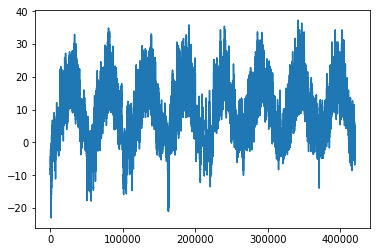

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
temp = float_data[:,1]
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(temp)), temp)

Plot dei primi dieci gioni

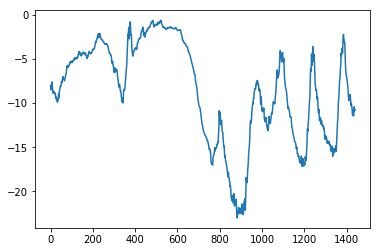

In [0]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(1440), temp[:1440])

### Preprocessing

Tengo il 70% delle osservazioni per allenare il modello (il 30% di queste verrà utilizzato come validation) e il restante 30% lo utilizzeremo per il test.

In [0]:
train_size = int(len(temp) * 0.70)

In [0]:
train = temp[:train_size]
test = temp[train_size:]

Bisogna creare delle sequenze input/output dove gli N valori precedenti vanno a predire il successivo. Al momento in output inseriamo un valore solo ma è possibile anche lavorare in multi-step.
<br>
La funzione ***split_sequence()*** serve a questo bisogno, creare delle finestre temporali.

In [0]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Avendo dati a 10 minuti vogliamo predire considerando l'ora precedente quindi il parametro *n_steps* verrà impostato a 6.

In [0]:
train_x, train_y = split_sequence(sequence= train, n_steps= 6)
test_x, test_y = split_sequence(sequence= test, n_steps= 6)

Vediamo i primi 10 elementi del train per capire il formato.

In [0]:
for i in range(10):
	print(train_x[i], train_y[i])

[-8.02 -8.41 -8.51 -8.31 -8.27 -8.05] -7.62
[-8.41 -8.51 -8.31 -8.27 -8.05 -7.62] -7.62
[-8.51 -8.31 -8.27 -8.05 -7.62 -7.62] -7.91
[-8.31 -8.27 -8.05 -7.62 -7.62 -7.91] -8.43
[-8.27 -8.05 -7.62 -7.62 -7.91 -8.43] -8.76
[-8.05 -7.62 -7.62 -7.91 -8.43 -8.76] -8.88
[-7.62 -7.62 -7.91 -8.43 -8.76 -8.88] -8.85
[-7.62 -7.91 -8.43 -8.76 -8.88 -8.85] -8.83
[-7.91 -8.43 -8.76 -8.88 -8.85 -8.83] -8.66
[-8.43 -8.76 -8.88 -8.85 -8.83 -8.66] -8.66


### Model: Simple Dense MLP

Creiamo una rete abbastanza semplice e sperimentiamo diversi tuning.

In [0]:
!pip install -U -q tensorflow

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Il primo modello è una rete semplice:

1.   ha uno strato con 8 neuroni, 6 sono i parametri di input.
2.   la funzione di attivazione è una Rectified Linear Unit (ReLU)
3.   la funzione obiettivo è l'errore quadratico medio
4.   optimizer adam [https://keras.io/optimizers/]
5.   alleniamo per 10 epoche inizialmente poi in caso si può incrementare
6.   batch_size più è basso meno sarà accurata la stima del gradiente ma ne beneficiano le performance e la generalizzazione
7.   steps_per_epoch è il numero di campioni prima di dichiarare un'epoca conclusa e passare alla prossima.
8.   il validation_split è la parte del dataset che viene utilizzata in fase di validazione del modello








In [0]:
model = Sequential()
model.add(Dense(8, input_dim=6, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [0]:
history = model.fit(train_x, train_y, epochs=10, batch_size=8, steps_per_epoch= 32 ,validation_split=0.3)

Epoch 1/10
32/32 [==============================] - 17s 539ms/step - loss: 134.2974 - val_loss: 85.7521
Epoch 2/10
32/32 [==============================] - 17s 530ms/step - loss: 56.6275 - val_loss: 19.2413
Epoch 3/10
32/32 [==============================] - 17s 529ms/step - loss: 15.7670 - val_loss: 4.5550
Epoch 4/10
32/32 [==============================] - 17s 529ms/step - loss: 10.6006 - val_loss: 3.7699
Epoch 5/10
32/32 [==============================] - 17s 525ms/step - loss: 8.8432 - val_loss: 3.1482
Epoch 6/10
32/32 [==============================] - 17s 523ms/step - loss: 7.1294 - val_loss: 2.4936
Epoch 7/10
32/32 [==============================] - 17s 527ms/step - loss: 5.3448 - val_loss: 1.8352
Epoch 8/10
32/32 [==============================] - 17s 529ms/step - loss: 3.6454 - val_loss: 1.2547
Epoch 9/10
32/32 [==============================] - 17s 527ms/step - loss: 2.2531 - val_loss: 0.8254
Epoch 10/10
32/32 [==============================] - 17s 528ms/step - loss: 1.3044 -

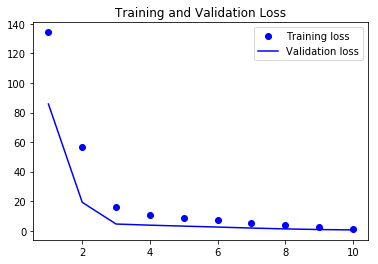

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Testiamo una seconda configurazione con più epoche e un diverso setting dei parametri, inseriamo anche lo shuffle.

In [0]:
history = model.fit(train_x, train_y, epochs=50, batch_size=8, steps_per_epoch= 128, shuffle=1, validation_split=0.3)

Epoch 1/50
128/128 [==============================] - 18s 139ms/step - loss: 0.0597 - val_loss: 0.0519
Epoch 2/50
128/128 [==============================] - 18s 138ms/step - loss: 0.0589 - val_loss: 0.0512
Epoch 3/50
128/128 [==============================] - 17s 135ms/step - loss: 0.0581 - val_loss: 0.0505
Epoch 4/50
128/128 [==============================] - 17s 134ms/step - loss: 0.0573 - val_loss: 0.0499
Epoch 5/50
128/128 [==============================] - 17s 135ms/step - loss: 0.0566 - val_loss: 0.0493
Epoch 6/50
128/128 [==============================] - 17s 134ms/step - loss: 0.0559 - val_loss: 0.0487
Epoch 7/50
128/128 [==============================] - 17s 134ms/step - loss: 0.0553 - val_loss: 0.0482
Epoch 8/50
128/128 [==============================] - 17s 135ms/step - loss: 0.0547 - val_loss: 0.0476
Epoch 9/50
128/128 [==============================] - 17s 135ms/step - loss: 0.0541 - val_loss: 0.0472
Epoch 10/50
128/128 [==============================] - 17s 134ms/step - l

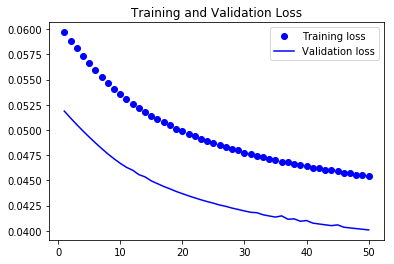

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [0]:
trainScore = model.evaluate(train_x, train_y, batch_size=8,verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(test_x, test_y, batch_size=8, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 0.04 MSE (0.21 RMSE)
Test Score: 0.04 MSE (0.21 RMSE)


In [0]:
trainPredict = model.predict(train_x, batch_size= 8)
testPredict = model.predict(test_x, batch_size=8)

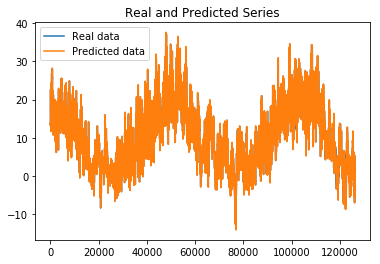

In [0]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(test_y)), test_y, label = 'Real data')
plt.plot(range(len(testPredict)), testPredict, label = 'Predicted data')
plt.title('Real and Predicted Series')
plt.legend()

plt.show()

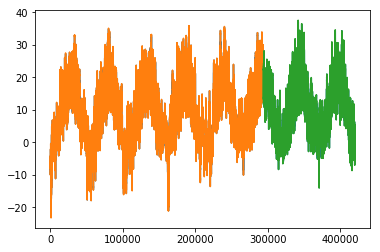

In [0]:
trainPredictPlot = np.empty_like(temp)
trainPredictPlot[:] = np.nan
trainPredictPlot[6:(len(trainPredict)+6)] = trainPredict[:,0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(temp)
testPredictPlot[:] = np.nan
testPredictPlot[(len(trainPredict)+(6*2)):len(temp)] = testPredict[:,0]
# plot baseline and predictions
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(temp)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Validazione numerica

Confrontiamo i primi 10 valori predetti e reali

In [0]:
testPredict[:10,0]

array([13.771059, 13.667763, 13.673071, 13.49193 , 13.495436, 13.513806,
       13.457093, 13.429043, 13.453822, 13.407852], dtype=float32)

In [0]:
test_y[:10]

array([13.73, 13.68, 13.55, 13.53, 13.53, 13.5 , 13.46, 13.46, 13.43,
       13.45])

Costruiamo un plot con sulle ascisse i valori reali e sulle ordinate le previsioni.
<br>
Di seguito colcoliamo l'R^2

Text(0, 0.5, 'Predicted Values')

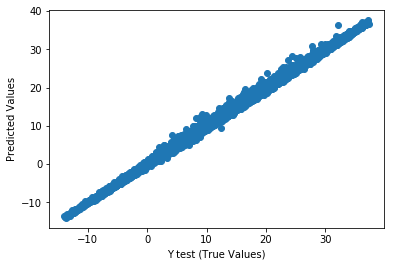

In [0]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.scatter(test_y, testPredict[:,0])
plt.xlabel('Y test (True Values)')
plt.ylabel('Predicted Values')

In [0]:
from sklearn.metrics import r2_score

In [0]:
print('r2 score: ', r2_score(test_y, testPredict[:,0]))

r2 score:  0.999301633064758


# OVERFITTING?